In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import os
from torchvision.io import read_image
from PIL import Image
plt.style.use('seaborn-v0_8')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/MyDrive/Dataset/Images'
files_images = os.listdir(folder_path)
print(len(files_images))

5017


## **Mendeteksi Duplikasi**

In [ ]:
duplicates = []
# Loop untuk memeriksa file duplikasi
for file_name in files_images:
    if "(1)" in file_name:
        original_file_name = file_name.replace("(1)", "")
        if original_file_name in files_images:
            duplicates.append(file_name)

print(f'Jumlah gambar duplikat yang ditemukan: {len(duplicates)}')
print('Daftar file duplikat:')
for duplicate in duplicates:
    print(duplicate)

Jumlah gambar duplikat yang ditemukan: 17
Daftar file duplikat:
182809(1).jpg
182912(1).jpg
182943(1).jpg
189297(1).jpg
189132(1).jpg
189581(1).jpg
189324(1).jpg
189513(1).jpg
189651(1).jpg
189512(1).jpg
183018(1).jpg
183111(1).jpg
183005(1).jpg
183050(1).jpg
183121(1).jpg
183145(1).jpg
182793(1).jpg


In [ ]:
# Mengumpulkan file images yang bukan duplikat
duplicates_set = set(duplicates)

# Filter file yang bukan duplikat
filtered_images = [file for file in files_images if file not in duplicates_set]

print(f'Total gambar setelah filter duplikat: {len(filtered_images)}')

Total gambar setelah filter duplikat: 5000


## **Membaca List Attribute**

In [ ]:
attributes_path = '/content/drive/MyDrive/Dataset/list_attribute.txt'

# Membaca file baris per baris
data = []
with open(attributes_path, 'r') as file:
    lines = file.readlines()

header_line = lines[1].strip().split()

for line in lines[2:]:
    parts = line.strip().split()
    if len(parts) == 41:
        data.append(parts)

attributes = pd.DataFrame(data)

# Menambahkan nama kolom id_images
attributes.columns = ['id_images'] + header_line

for col in header_line:
    attributes[col] = attributes[col].astype(int)

# Mengganti -1 dengan 0
attributes.replace(-1, 0, inplace=True)

print(attributes.head())

    id_images  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                 0                1           1                0   
1  000002.jpg                 0                0           0                1   
2  000003.jpg                 0                0           0                0   
3  000004.jpg                 0                0           1                0   
4  000005.jpg                 0                1           1                0   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0     0      0         0         0           0  ...          0        1   
1     0      0         0         1           0  ...          0        1   
2     0      0         1         0           0  ...          0        0   
3     0      0         0         0           0  ...          0        0   
4     0      0         1         0           0  ...          0        0   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  We

Saya ubah nilai -1 menjadi 0 karena model vgg tidak bisa (error) ketika menggunakan nilai -1

### **Mapping gambar ke atribut**

In [ ]:
filtered_attributes = attributes[attributes['id_images'].isin(filtered_images)]

# Cek jumlah gambar yang berhasil ditemukan
print(f"Jumlah gambar yang ditemukan: {len(filtered_attributes)} dari {len(filtered_images)} gambar")
print(filtered_attributes.head())

Jumlah gambar yang ditemukan: 5000 dari 5000 gambar
      id_images  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
50   000051.jpg                 1                0           0   
51   000052.jpg                 0                0           0   
64   000065.jpg                 0                0           0   
165  000166.jpg                 1                0           0   
197  000198.jpg                 0                1           1   

     Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
50                 1     1      0         0         1           0  ...   
51                 1     0      0         0         1           0  ...   
64                 0     0      0         0         0           1  ...   
165                0     0      0         0         1           0  ...   
197                0     0      0         0         0           0  ...   

     Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
50           0        0            

### **Plotting dengan Pie chart**

Jumlah Female: 2953
Jumlah Male: 2047


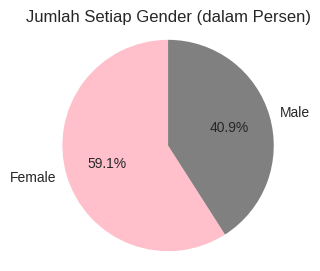

In [ ]:
# Menghitung jumlah setiap gender
gender_count = filtered_attributes['Male'].value_counts()
labels = ['Female', 'Male']
sizes = [gender_count.get(0, 0), gender_count.get(1, 0)]
colors = ['pink', 'gray']
print(f'Jumlah Female: {sizes[0]}')
print(f'Jumlah Male: {sizes[1]}')

# Buat pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Jumlah Setiap Gender (dalam Persen)')
plt.show()

Data perbandingan antara Female dan Male agak imbalance namun tidak terlalu signifikan

### **Melihat sample gambar top 5**

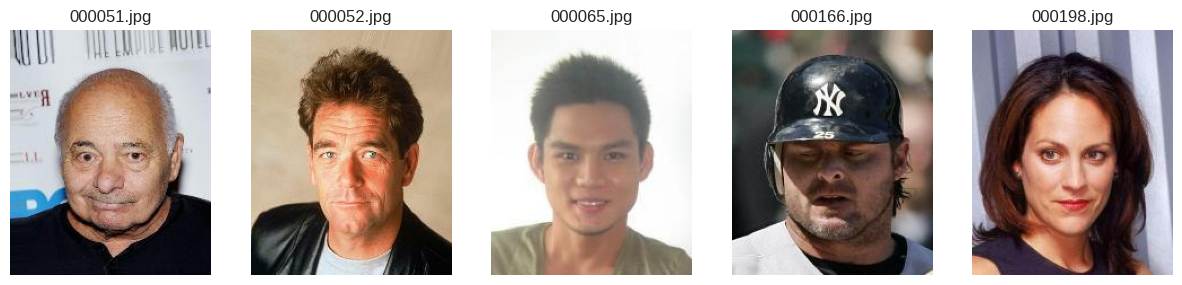

In [ ]:
import matplotlib.pyplot as plt

image_dir = '/content/drive/MyDrive/Dataset/Images/'
samples = filtered_attributes[['id_images']].head(5)
plt.figure(figsize=(15, 15))

# Loop setiap sampel
for i, sample in enumerate(samples.iterrows()):
    image_name = sample[1]['id_images']
    image_path = os.path.join(image_dir, image_name)

    # Open gambar
    img = Image.open(image_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(image_name)
    plt.axis('off')

plt.show()

## **Data Preprocessing**

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Transform for face recognition images
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset Class
class GenderDataset(Dataset):
    def __init__(self, image_dir, dataframe, transform=None):
        self.image_dir = image_dir
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        label = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.long)
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image, label

### **Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

# Define the training parameters
batch_size = 128
learning_rate = 0.001
epochs = 10

filtered_attributes = filtered_attributes[['id_images', 'Male']]

# split the data into train and test sets with a 80:20 ratio
train_attributes, test_attributes = train_test_split(filtered_attributes, test_size=0.2, random_state=42)

image_dir = '/content/drive/MyDrive/Dataset/Images/'

train_data = GenderDataset(image_dir, train_attributes, transform=transform)
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = GenderDataset(image_dir, test_attributes, transform=transform)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
print(train_attributes['Male'].value_counts())
print(test_attributes['Male'].value_counts())

Male
0    2357
1    1643
Name: count, dtype: int64
Male
0    596
1    404
Name: count, dtype: int64


## **Melatih Model VGG16**

In [ ]:
import time
import torchvision.models as models
from torch.autograd import Variable

model = models.vgg16(weights=models.VGG16_Weights.DEFAULT) # sama dengan pretrained=True, tapi tidak mendukung di versi baru
model.classifier[6] = nn.Linear(4096, 2)
model = model.to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

since = time.time()
best_model_wts = model.state_dict()
best_acc = 0.0

train_accuracies = []
test_accuracies = []

# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print statistics every 30 mini-batches
        if i % 30 == 29:
            print('[Epoch %d, Batch %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0

    # Calculate training accuracy
    train_acc = 100 * correct / total
    train_accuracies.append(train_acc)
    print(f'Training Accuracy: {train_acc:.2f}%')

    # Test the model
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_acc = 100 * correct / total
    epoch_loss = running_loss / len(testloader)
    test_accuracies.append(epoch_acc)
    print(f'Test Loss: {epoch_loss:.4f} | Test Accuracy: {epoch_acc:.2f}%')

    # Save the model if it has the best accuracy so far
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = model.state_dict()

# Total time elapsed
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best test accuracy: {:4f}'.format(best_acc))

model.load_state_dict(best_model_wts)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.9MB/s]


[Epoch 1, Batch    30] loss: 1.016
Training Accuracy: 52.85%
Test Loss: 0.6741 | Test Accuracy: 59.60%
[Epoch 2, Batch    30] loss: 0.678
Training Accuracy: 58.20%
Test Loss: 0.6774 | Test Accuracy: 59.60%
[Epoch 3, Batch    30] loss: 0.651
Training Accuracy: 60.70%
Test Loss: 0.5679 | Test Accuracy: 71.30%
[Epoch 4, Batch    30] loss: 0.497
Training Accuracy: 76.50%
Test Loss: 0.4450 | Test Accuracy: 77.70%
[Epoch 5, Batch    30] loss: 0.391
Training Accuracy: 82.80%
Test Loss: 0.4015 | Test Accuracy: 81.10%
[Epoch 6, Batch    30] loss: 0.355
Training Accuracy: 85.20%
Test Loss: 0.3264 | Test Accuracy: 86.30%
[Epoch 7, Batch    30] loss: 0.301
Training Accuracy: 87.55%
Test Loss: 0.3014 | Test Accuracy: 88.40%
[Epoch 8, Batch    30] loss: 0.276
Training Accuracy: 88.40%
Test Loss: 0.3345 | Test Accuracy: 88.50%
[Epoch 9, Batch    30] loss: 0.257
Training Accuracy: 89.67%
Test Loss: 0.2965 | Test Accuracy: 89.00%
[Epoch 10, Batch    30] loss: 0.238
Training Accuracy: 90.12%
Test Loss: 

<All keys matched successfully>

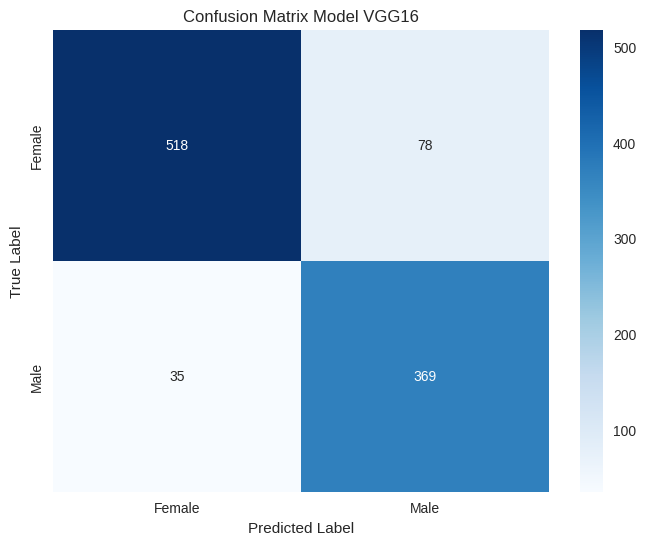

Classification Report:
              precision    recall  f1-score   support

      Female       0.94      0.87      0.90       596
        Male       0.83      0.91      0.87       404

    accuracy                           0.89      1000
   macro avg       0.88      0.89      0.88      1000
weighted avg       0.89      0.89      0.89      1000



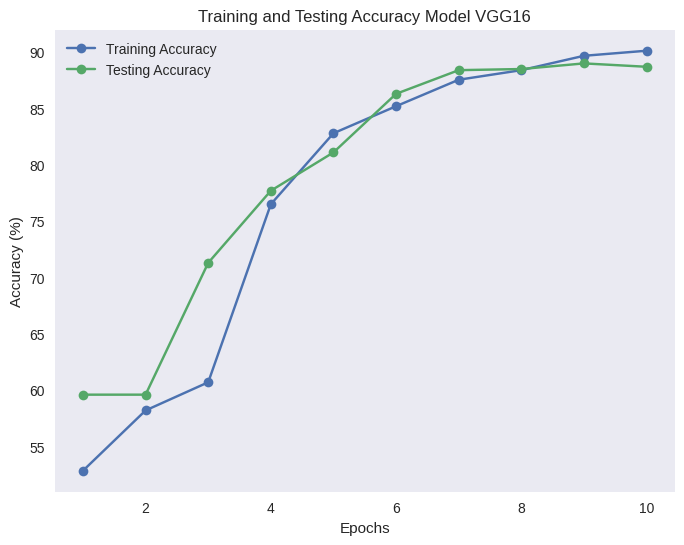

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix Model VGG16')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('/content/drive/My Drive/confusion_matrix_vgg16.png')
    plt.show()

# Calculate and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, classes=['Female', 'Male'])

# Print classification report
report = classification_report(all_labels, all_preds, target_names=['Female', 'Male'])
print("Classification Report:")
print(report)

# Plotting accuracy chart
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs + 1), test_accuracies, label='Testing Accuracy', marker='o')
plt.title('Training and Testing Accuracy Model VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.savefig('/content/drive/My Drive/accuracy_chart_vgg16.png')
plt.show()

Dari hasil Confusion Matrix dan Classification Report model sudah memiliki performa yang baik dalam memprediksi gender, dengan akurasi 89%. Nilai Precision untuk memprediksi pada Female > Male dengan nilai 94% dan Male 83%. Nilai Recall untuk memprediksi yang benar-benar Male dan Female, Male > Female dengan nilai 91% dan Female 87%. Dan rata-rata harmoni yakni F1 Score Female dan Male masing-masing 90% dan 87%. Secara keseluruhan performa model sudah baik, namun bisa lebih ditingkatkan lagi menggunakan Hyperparameter Tuning.

### **Hyperparameter Tuning dengan Random Search**

In [ ]:
import random
from sklearn.metrics import accuracy_score

# Transform for face recognition images
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Hyperparameter space
learning_rates = [0.00001, 0.0001, 0.001]
batch_sizes = [8, 16, 32, 64, 128]
num_epochs_list = [5, 10, 15, 20, 25, 30]

# Fungsi untuk melatih model
def train_model(learning_rate, batch_size, num_epochs):
    train_data = GenderDataset(image_dir, train_attributes, transform=transform)
    test_data = GenderDataset(image_dir, test_attributes, transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    model.classifier[6] = nn.Linear(4096, 2)
    model = model.to('cuda')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Latih model
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluasi model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Random search
num_trials = 10
best_accuracy = 0
best_params = {}

for _ in range(num_trials):
    learning_rate = random.choice(learning_rates)
    batch_size = random.choice(batch_sizes)
    num_epochs = random.choice(num_epochs_list)
    print(f"Training with lr={learning_rate}, batch_size={batch_size}, epochs={num_epochs}")

    accuracy = train_model(learning_rate, batch_size, num_epochs)
    print(f"Accuracy: {accuracy}")

    # Update jika ditemukan hasil yang lebih baik
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs
        }

print("Best hyperparameters: ", best_params)
print("Best accuracy: ", best_accuracy)

Training with lr=1e-05, batch_size=16, epochs=25
Accuracy: 0.976
Training with lr=0.0001, batch_size=8, epochs=20
Accuracy: 0.975
Training with lr=0.0001, batch_size=32, epochs=25
Accuracy: 0.979
Training with lr=0.0001, batch_size=8, epochs=5
Accuracy: 0.969
Training with lr=1e-05, batch_size=32, epochs=10
Accuracy: 0.965
Training with lr=1e-05, batch_size=32, epochs=30
Accuracy: 0.973
Training with lr=1e-05, batch_size=32, epochs=20
Accuracy: 0.976
Training with lr=0.0001, batch_size=64, epochs=5
Accuracy: 0.95
Training with lr=1e-05, batch_size=64, epochs=5
Accuracy: 0.963
Training with lr=0.001, batch_size=16, epochs=25


Hasil Hyperparameter Tuning menggunakan Random Search ini terhenti di iterasi ke-10 karena GPU yang terhubung terputus karena limit habis. Namun dari hasil ini, kita bisa menggunakan paremeter iterasi yang ke-3, yakni learning_rates=0.0001, batch_size=32, epochs=25 untuk meningkatkan performa model menjadi lebih baik lagi.

## **Menerapkan Hyperparameter Tuning**

In [ ]:
# Define the training parameters
batch_size = 32
learning_rate = 0.0001
epochs = 25

filtered_attributes = filtered_attributes[['id_images', 'Male']]

# split the data into train and test sets with a 80:20 ratio
train_attributes, test_attributes = train_test_split(filtered_attributes, test_size=0.2, random_state=42)

image_dir = '/content/drive/MyDrive/Dataset/Images/'

train_data = GenderDataset(image_dir, train_attributes, transform=transform)
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = GenderDataset(image_dir, test_attributes, transform=transform)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
import time
import torchvision.models as models
from torch.autograd import Variable

model = models.vgg16(weights=models.VGG16_Weights.DEFAULT) # sama dengan pretrained=True, tapi tidak mendukung di versi baru
model.classifier[6] = nn.Linear(4096, 2)
model = model.to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

since = time.time()
best_model_wts = model.state_dict()
best_acc = 0.0

train_accuracies = []
test_accuracies = []

# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print statistics every 100 mini-batches
        if i % 100 == 99:
            print('[Epoch %d, Batch %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Calculate training accuracy
    train_acc = 100 * correct / total
    train_accuracies.append(train_acc)
    print(f'Training Accuracy: {train_acc:.2f}%')

    # Test the model
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_acc = 100 * correct / total
    epoch_loss = running_loss / len(testloader)
    test_accuracies.append(epoch_acc)
    print(f'Test Loss: {epoch_loss:.4f} | Test Accuracy: {epoch_acc:.2f}%')

    # Save the model if it has the best accuracy so far
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = model.state_dict()

# Total time elapsed
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best test accuracy: {:4f}'.format(best_acc))

model.load_state_dict(best_model_wts)

[Epoch 1, Batch   100] loss: 0.226
Training Accuracy: 91.55%
Test Loss: 0.2038 | Test Accuracy: 92.10%
[Epoch 2, Batch   100] loss: 0.099
Training Accuracy: 96.33%
Test Loss: 0.1392 | Test Accuracy: 96.20%
[Epoch 3, Batch   100] loss: 0.080
Training Accuracy: 97.35%
Test Loss: 0.1030 | Test Accuracy: 96.80%
[Epoch 4, Batch   100] loss: 0.060
Training Accuracy: 97.65%
Test Loss: 0.1027 | Test Accuracy: 96.80%
[Epoch 5, Batch   100] loss: 0.051
Training Accuracy: 97.53%
Test Loss: 0.1673 | Test Accuracy: 95.00%
[Epoch 6, Batch   100] loss: 0.041
Training Accuracy: 98.60%
Test Loss: 0.0948 | Test Accuracy: 97.90%
[Epoch 7, Batch   100] loss: 0.034
Training Accuracy: 98.55%
Test Loss: 0.1309 | Test Accuracy: 96.80%
[Epoch 8, Batch   100] loss: 0.034
Training Accuracy: 98.28%
Test Loss: 0.1151 | Test Accuracy: 97.20%
[Epoch 9, Batch   100] loss: 0.035
Training Accuracy: 98.65%
Test Loss: 0.1295 | Test Accuracy: 97.60%
[Epoch 10, Batch   100] loss: 0.030
Training Accuracy: 98.97%
Test Loss: 

<All keys matched successfully>

Model menunjukkan hasil akurasi yang sangat baik mulai dari Epoch 1. Mungkin ini disebabkan model sudah melakukan transfer learning dari model sebelum menggunakan Hyperparemeter tuning, sehingga hasilnya sudah sangat baik dari awal. Dari hasil tersebut Akurasi test terbaik di angka 98.2%

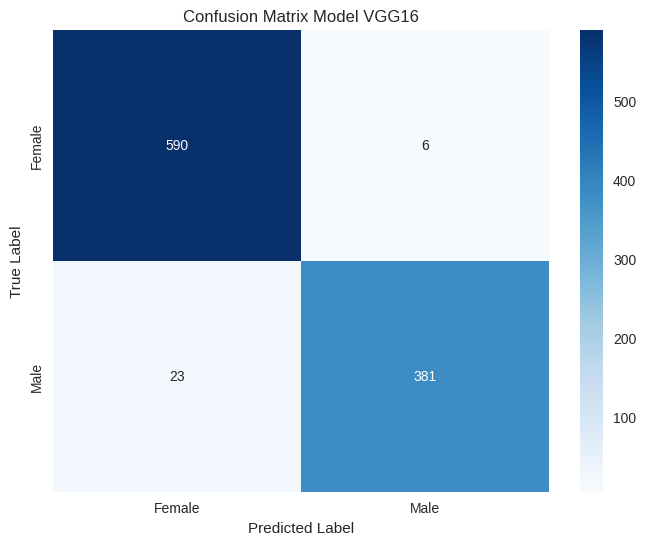

Classification Report:
              precision    recall  f1-score   support

      Female       0.96      0.99      0.98       596
        Male       0.98      0.94      0.96       404

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



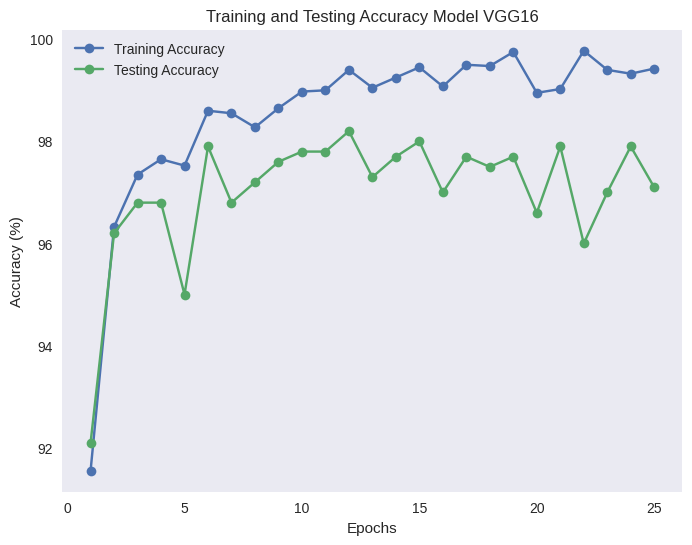

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix Model VGG16')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('/content/drive/My Drive/confusion_matrix_vgg16_2.png')
    plt.show()

# Calculate and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, classes=['Female', 'Male'])

# Print classification report
report = classification_report(all_labels, all_preds, target_names=['Female', 'Male'])
print("Classification Report:")
print(report)

# Plotting accuracy chart
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs + 1), test_accuracies, label='Testing Accuracy', marker='o')
plt.title('Training and Testing Accuracy Model VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.savefig('/content/drive/My Drive/accuracy_chart_vgg16_2.png')
plt.show()

Dari hasil Confusion Matrix dan Classification Report pada model yang sudah menerapkan Hyperparameter Tuning dengan Random Search ini memiliki performa yang sangat baik dalam memprediksi gender, dengan akurasi 97%. Nilai Precision untuk memprediksi pada Male > Female dengan nilai 98% dan Female 96%. Nilai Recall untuk memprediksi yang benar-benar Female dan Male, Female > Male dengan nilai 99% dan Male 94%. Dan rata-rata harmoni yakni F1 Score Female dan Male masing-masing 98% dan 96%. Secara keseluruhan performa model sudah sangat baik, sehingga bisa dikatakan penerapan parameter dengan learning_rates=0.0001, batch_size=32, epochs=25 menggunakan Hyperparameter Tuning Random Search berhasil meningkatkan performa model dengan sangat signifikan.